### Discrete Data + Probability
- Use basic probability to **identify anomalous request methods**. You will want to make sure the text is normalized in order to reduce the noise.

In [1]:
# Import libraries

from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

### Wrangle Data

In [24]:
# Acquire

colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [25]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [26]:
# Parse Datetime

df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [27]:
# Cleanup Text

for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [28]:
# Add Variable - Converting bytes to mb

df['size_mb'] = [n/1024/1024 for n in df['size']]
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Detecting Anomalies in Discrete Variables
### Finding anomalies in already existing data
We can easily see some anomalies around IP addresses.

In [34]:
request_method_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                                    rename(index=str, columns={'index': 'request_method', 
                                                               'request_method': 'count'})

request_method_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).\
                        reset_index().rename(index=str, columns={'index': 'request_method', 
                                                                 'request_method': 'proba'})

request_method_df = request_method_df.merge(request_method_df2)

In [35]:
request_method_df.head()

,request_method,count,proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154


In [36]:
# see those where rate < 1% 
request_method_df[request_method_df.proba < .01]

,request_method,count,proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/itemsitems HTTP/1.1,3,0.000215
11,GET /api/v1/sales/HTTP/1.1,3,0.000215
12,GET /api/v1/sales/ HTTP/1.1,3,0.000215


22
                                  request_method  count     proba
12                   GET /api/v1/sales/ HTTP/1.1      3  0.000215
13                    GET /api/v1/store HTTP/1.1      3  0.000215
14                     GET /api/v1items HTTP/1.1      2  0.000143
15                  GET /api/V1/HiZach! HTTP/1.1      1  0.000072
16                          GET /api/v1 HTTP/1.1      1  0.000072
17             GET /api/v1/items&page=0 HTTP/1.1      1  0.000072
18              GET /api/v1/helloclass! HTTP/1.1      1  0.000072
19        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1      1  0.000072
20  GET /api/v1//api/v1/items/next_page HTTP/1.1      1  0.000072
21                    GET /api/v1/items/HTTP/1.1      1  0.000072


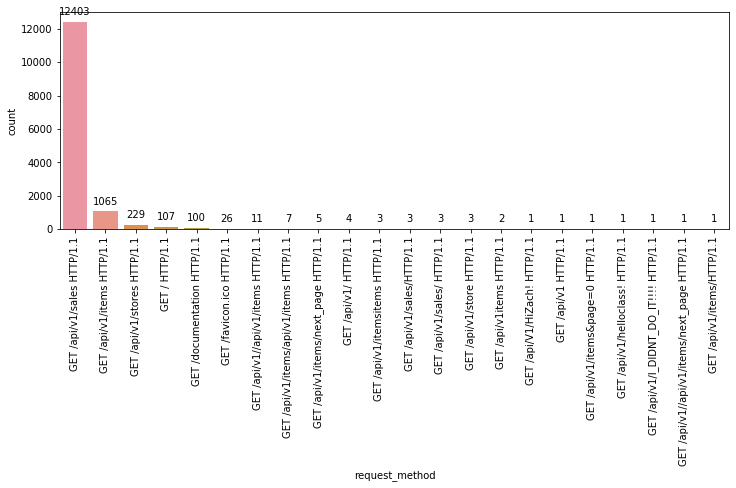

In [37]:
print(len(request_method_df))

print(request_method_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_method_df, x = 'request_method', y = 'count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.

In [38]:
# Establish Baseline based on time

train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14']\
        [['ip','request_method','status','size','destination','request_agent','size_mb']]

In [39]:
# Compute probabilities based on train sample:

request_method_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/df.request_method.count()).\
                                    reset_index().rename(index=str, columns={'index': 'request_method', 
                                                                 'request_method': 'proba'})

In [40]:
# Merge probabilities with all data (train + new data)
# Fill the probability with a value of 0 for the new request methods

df1 = df.copy()

df1 = df1.reset_index().merge(request_method_df, 
                              on=['request_method'], 
                              how='left').fillna(value=0).set_index('timestamp')

df1.proba.value_counts().sort_index(ascending=False)

0.887323    12403
0.076191     1065
0.016383      229
0.007655      107
0.007154      100
0.001860       26
0.000787       11
0.000501        7
0.000358        5
0.000286        4
0.000215        9
0.000143        2
0.000072        6
0.000000        4
Name: proba, dtype: int64

### Conditional Probabilites: Probabilites using 2 discrete variables
#### Probability of Status given request method
If we are looking for an unexpected status (like authentication failure) from a known/common request method.

In [42]:
# Compute the probability of request methods 

request_method_probs = train.groupby('request_method').size().div(len(df))

In [46]:
# Compute the probability of status given request method

status_given_request_method = pd.DataFrame(train.groupby(['request_method', 'status']).size().\
                                           div(len(train)).\
                                           div(request_method_probs, axis=0, level='request_method').\
                                           reset_index().\
                                           rename(index=str, 
                                           columns={0: 'proba_status_given_request_method'})
                                          )

In [47]:
request_method_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])\
                                           ['ip'].count().reset_index().\
                                           rename(index=str, columns={'ip': 'request_method_status_count'}))

request_method_status = status_given_request_method.merge(request_method_status_count)

request_method_status.head()

,request_method,status,proba_status_given_request_method,request_method_status_count
0,GET / HTTP/1.1,200,1.000286,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000286,1
2,GET /api/v1 HTTP/1.1,200,1.000286,1
3,GET /api/v1/ HTTP/1.1,200,1.000286,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000286,11


In [50]:
# Add these probabilities to original events to detect anomalous events:

df2 = df1.copy()

df2 = df2.reset_index().merge(request_method_status, on=['request_method', 'status'], how='left').\
        fillna(value=0).set_index('timestamp')

df2.head()

,ip,request_method,status,size,destination,request_agent,size_mb,proba,proba_status_given_request_method,request_method_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.887323,0.999318,12391.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076191,0.996529,1061.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.887323,0.999318,12391.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.887323,0.999318,12391.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.887323,0.999318,12391.0


Text(0, 0.5, 'P(seeing this given request method)')

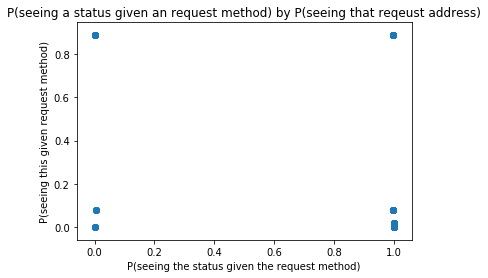

In [54]:
plt.scatter(df2.proba_status_given_request_method, df2.proba)
plt.title("P(seeing a status given an request method) by P(seeing that reqeust address)")
plt.xlabel("P(seeing the status given the request method)")
plt.ylabel("P(seeing this given request method)")